# **Введение**
Стартап продаёт продукты питания.\
Нужно выяснить, как ведут себя пользователи мобильного приложения.
Для этого будет изучена воронка продаж. Установлен путь, которой пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно.\
\
После этого будет проведено исследование результатов A/A/B-эксперимента.\
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры считают, что пользователям будет непривычно.\
Решение будет принято по результатам A/A/B-теста.\
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.\
\
**Задача:** выяснить, какой шрифт лучше.\
\
Создание двух групп A вместо одной имеет определённые преимущества:
  - Если две контрольные группы окажутся равны, то можно быть увереным в точности проведенного тестирования.
  - Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов.

Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.
В случае общей аналитики и A/A/B-эксперимента работа осуществляется с одними и теми же данными.\
\
**Описание данных**\
Каждая запись в логе — это действие пользователя, или событие.\
*EventName* — название события;\
*DeviceIDHash* — уникальный идентификатор пользователя;\
*EventTimestamp* — время события;\
*ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.\
\
**Этапы анализа данных**\
\
Этап 1. Изучение общей информации.\
Путь к файлу: /datasets/logs_exp.csv.\
\
Этап 2. Подготовка данных
- Замена названий столбцов на удобные;
- Проверка наличия пропусков и типов данных;
- Добавление столбца даты.

Этап 3. Изучение и проверка данных
- Сколько всего событий в логе.
- Сколько всего пользователей в логе.
- Сколько в среднем событий приходится на пользователя.
- Данными за какой период имеются. Поиск максимальной и минимальной даты. Построение гистограммы по дате и времени. Определение момента с которого данные полные. Отброс более старых.
- Сколко событий и пользователей потеряно после отброса старых данных.
- Проверка наличия пользователи из всех трёх экспериментальных групп.

Этап 4. Воронка событий
- События есть в логах, как часто они встречаются. Сортировка событий по частоте.
- Сколько пользователей совершали каждое из этих событий. Сортировка событий по числу пользователей. Долю пользователей, которые хоть раз совершали событие.
- Возможный порядок событий.
- Расчёт по воронке событий: какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
- Определение шага на котором теряется больше всего пользователей.
- Доля пользователей, которая доходит от первого события до оплаты.

Этап 5. Эксперимент. Результаты
- Кол-во пользователей в каждой экспериментальной группе.
- Контрольные группы для А/А-эксперимента (246, 247): проверка корректности всех механизмов и расчётов.
- Самое популярное событие. Подсчёт числа пользователей, совершивших это событие в каждой из контрольных групп. Подсчёт доли пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Подсчёт для всех других событий. Корректность разбиения на группы.
- Аналогичный подсчёт с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Результаты.

# **Анализ данных**

# Этап 1. Общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth
import plotly.io as pio
pio.renderers.default = 'png'

path = 'D:/Я.Практикум/Sprint 15 Combined project 2 AAB-test/'
logs = pd.read_csv(path + 'logs_exp.csv', sep='\t')
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [2]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В датафрейме 4 столбца, 244 126 строк. Пропусков данных нет. Тип данных в столбце EventTimestamp будет преобразован в дату и время. Типы данных в остальных столбцах приемлемы для дальнейшего исследования.

# Этап 2. Подготовка данных

- Замена названий столбцов на удобные;
- Проверка наличия пропусков и типов данных;
- Добавление столбца даты.

In [3]:
logs.duplicated().mean() # проверка наличия дубликатов

0.0016917493425526163

In [4]:
logs = logs[~logs.duplicated()] # исключение дубликатов из датафрейма

In [5]:
logs.duplicated().mean() # проверка наличия дубликатов после очистки от дубликатов

0.0

In [6]:
logs['EventTimestamp'] = pd.to_datetime(logs['EventTimestamp'], unit='s') # преобразование столбца с датой и временем

logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [7]:
logs.columns = ['event_name', 'user_id', 'event_time', 'group']
logs.head(5)

,event_name,user_id,event_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [8]:
print(logs['event_name'].unique()) # наименования имеюшихся событий
print(logs['group'].value_counts()) # размеры групп

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
248    85582
246    80181
247    77950
Name: group, dtype: int64


In [9]:
# проверка вхождения одного и того же устройства в несколько групп
g246 = logs[logs['group'] == 246]['user_id']
g247 = logs[logs['group'] == 247]['user_id']
g248 = logs[logs['group'] == 248]['user_id']
print(list(set(g246).intersection(set(g247)))) # в 246 и 247
print(list(set(g246).intersection(set(g248)))) # в 246 и 248
print(list(set(g247).intersection(set(g248)))) # в 247 и 248

[]
[]
[]


Данные проверены.\
Пропусков данных нет.\
Дубликаты записей устранены.\
Пользователи, входящие сразу в несколько групп, отсутствуют.\
В данных присутствуют только группы соответствующие описанию и целям исследования: 246, 247, 248.

In [10]:
logs['event_date'] = pd.to_datetime(logs['event_time'].dt.date) # добавление столбца с датой

In [11]:
logs.head(5)

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


# Этап 3. Изучение и проверка данных

- Сколько всего событий в логе.
- Сколько всего пользователей в логе.
- Сколько в среднем событий приходится на пользователя.
- Данными за какой период имеются. Поиск максимальной и минимальной даты. Построение гистограммы по дате и времени. Определение момента с которого данные полные. Отброс более старых.
- Сколко событий и пользователей потеряно после отброса старых данных.
- Проверка наличия пользователи из всех трёх экспериментальных групп.

In [12]:
logs['event_name'].count()

243713

In [13]:
logs['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

В логе 243 713 событий.\
События разбиты на 5 уникальных:\
`MainScreenAppear` - показ главной сраницы,\
`OffersScreenAppear` - показ предложений,\
`CartScreenAppear` - показ корзины,\
`PaymentScreenSuccessful` - показ страницы успешной оплаты,\
`Tutorial` - руководство (обучение).

In [14]:
uniq_users = logs['user_id'].nunique()
uniq_users

7551

In [15]:
logs.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
246,2489
247,2520
248,2542


В логе 7551 уникальный пользователь. Группы пользователей близки по размеру.

In [16]:
events_on_us_mean = round(logs['event_name'].count()/uniq_users, 1)
events_on_us_mean

32.3

В среднем на одного пользователя приходится 33 события.

In [17]:
print('Дата начала теста:', logs['event_date'].min())
print('Дата окончания теста:', logs['event_date'].max())

Дата начала теста: 2019-07-25 00:00:00
Дата окончания теста: 2019-08-07 00:00:00


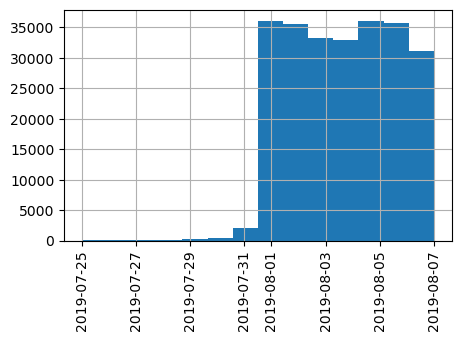

In [18]:
plt.figure(figsize=(5, 3))
logs['event_date'].hist(bins=14)
plt.xticks(rotation=90);

Из гистограммы видно, что значительный объём данных сосредоточен с 01-08-2019 по 07-08-2019. С 25 по 31 июля 2019 года данные не полные, из дальнейшего анализа их лучше исключить, чтобы они не привели к перекосу результатов. 

In [19]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   event_date  243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


In [20]:
old_logs = logs[logs['event_date'] < '2019-08-01']
print('Кол-во "доехавших" записей:', len(old_logs))
print('% "доехавших" от общего числа:', round(len(old_logs)*100/len(logs),2))

Кол-во "доехавших" записей: 2826
% "доехавших" от общего числа: 1.16


Количество записей в датафрейме, которые являются не полными, т.е. не входят в преобладающее большинство, составляет около 1% от общего числа. Их можно исключить из анализа для получения более достоверных результатов.

In [21]:
new_logs = logs[logs['event_date'] >= '2019-08-01']

In [22]:
nl = new_logs.groupby('group').agg({'event_name':'count'}) # датафрейм после удаления "доехавших" данных
l = logs.groupby('group').agg({'event_name':'count'}) # исходный датафрей

# собираем данные в одном датафрейме
diff_event = nl.merge(l, left_on='group', right_on='group', suffixes=['_new', '_old'])
diff_event['cleared, %'] = round((1 - diff_event['event_name_new'] / diff_event['event_name_old']) * 100, 2)
diff_event

,event_name_new,event_name_old,"cleared, %"
group,,,
246,79302,80181,1.10
247,77022,77950,1.19
248,84563,85582,1.19


После очистки отброшено около 1,2% данных по событиям.

In [23]:
nl = new_logs.groupby('group').agg({'user_id':'nunique'})
l = logs.groupby('group').agg({'user_id':'nunique'})

# собираем данные в одном датафрейме
diff_users = nl.merge(l, left_on='group', right_on='group', suffixes=['_new', '_old'])
diff_users['cleared, %'] = round((1 - diff_users['user_id_new']/diff_users['user_id_old']) * 100, 2)
diff_users

,user_id_new,user_id_old,"cleared, %"
group,,,
246,2484,2489,0.20
247,2513,2520,0.28
248,2537,2542,0.20


In [24]:
new_logs['user_id'].nunique()

7534

После очистки отброшено около 0,2% пользователей. Было 7751, стало 7534.

# Этап 4. Воронка событий

- События есть в логах, как часто они встречаются. Сортировка событий по частоте.
- Сколько пользователей совершали каждое из этих событий. Сортировка событий по числу пользователей. Долю пользователей, которые хоть раз совершали событие.
- Возможный порядок событий.
- Расчёт по воронке событий: какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
- Определение шага на котором теряется больше всего пользователей.
- Доля пользователей, которая доходит от первого события до оплаты.

In [25]:
# Посмотр событий в логах, как часто они встречаются, сортировка события по частоте.
new_logs['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Самым частым событие в логах является просмотр главной страницы, затем просмотр предложений, просмотр корзины, страница успешной оплаты и меньше всего просматривали руководство. 

In [26]:
all_event_users = (new_logs
                   .groupby('user_id')
                   .agg({'event_name':'nunique'})
                   .query('event_name == 5')
                  )
print(len(all_event_users),'пользователей совершили каждое из 5 видов событий, зафиксированных в логах.')

466 пользователей совершили каждое из 5 видов событий, зафиксированных в логах.


In [27]:
# подсчет кол-ва пользователей совершивших каждое из событий c сортировкой по числу пользователей
# подсчёт доли пользователей, которые хоть раз совершали событие
event_users = (new_logs
               .groupby('event_name', as_index=False)
               .agg({'user_id':'nunique'})
               .sort_values('user_id', ascending=False)
               .assign(percent_of_total = lambda x: round(x['user_id'] * 100 / new_logs['user_id'].nunique(), 2))
              )
               
event_users

,event_name,user_id,percent_of_total
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Из данной таблицы видно, что:\
98,47% пользователей хотя бы раз просматривали главную страницу,\
60,96% - просмотрели предложения,\
49,56% - просмотрели корзину покупок,\
46,97% - успешно оплатили заказ,\
11,15% - просматривали руководство.\
\
По процентным значениям имеющейся воронки событий и по логике совершения покупок в интернет-магазине предположительный порядок событий следующий:
1. Просмотр главной страницы
2. Просмотр предложений
3. Просмотр корзины
4. Страница успешной оплаты заказа

При этом имеется некое руководство (обучение), вероятно, оно показывает, как совершать покупки в данном интернет-магазине. Чаще всего руководство можно пропустить, поэтому всего 11,15% от всех пользователей просмотрели его. Так как его просмотр является необязательным и не влияет на осуществление остальных событий, он может быть любым в очереди, но наиболее возможный вариант - сразу после попадания на главную страницу, возможно, при первом посещении, когда пользователь только знакомится с магазином. И тогда возможная очередность событий выгядит так:
1. Просмотр главной страницы
2. Просмотр руководства
3. Просмотр предложений
4. Просмотр корзины
5. Страница успешной оплаты заказа

Для дальнейшего анализа воронки продаж будем рассматривать только события, которые пользователь не может пропустить для совершения покупки, то есть:
1. Просмотр главной страницы
2. Просмотр предложений
3. Просмотр корзины
4. Страница успешной оплаты заказа

In [28]:
funnel = event_users.drop(index=4)

funnel

,event_name,user_id,percent_of_total
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


In [29]:
funnel.assign(percent_of_previous = lambda x: round(x['user_id'] * 100 / x['user_id'].shift(), 2))\
      .assign(loss_of_previous = lambda x: round((1 - x['user_id'] / x['user_id'].shift()) * 100, 2))\
      .assign(percent_of_initial = lambda x: round(x['user_id'] * 100 / funnel['user_id'].max(), 2))

,event_name,user_id,percent_of_total,percent_of_previous,loss_of_previous,percent_of_initial
1,MainScreenAppear,7419,98.47,NaN,NaN,100.00
2,OffersScreenAppear,4593,60.96,61.91,38.09,61.91
0,CartScreenAppear,3734,49.56,81.30,18.70,50.33
3,PaymentScreenSuccessful,3539,46.97,94.78,5.22,47.70


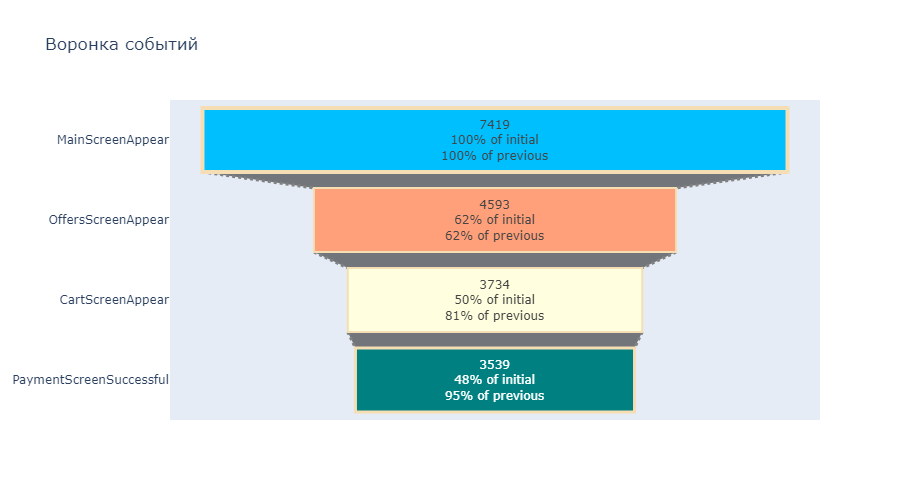

In [30]:
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial+percent previous",
    opacity = 1, marker = {"color": ["deepskyblue", "lightsalmon", "lightyellow", "teal"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "grey", "dash": "dot", "width": 3}})
    )
fig.update_layout(title="Воронка событий", width=900, height=500)
fig.show()

Самым частым событие в логах является просмотр главной страницы, затем просмотр предложений, просмотр корзины, страница успешной оплаты и меньше всего просматривали руководство.\
466 пользователей совершили каждое из 5 видов событий, зафиксированных в логах.\
Из таблицы видно, что:\
98,47% пользователей хотя бы раз просматривали главную страницу,\
60,96% - просмотрели предложения,\
49,56% - просмотрели корзину покупок,\
46,97% - успешно оплатили заказ,\
11,15% - просматривали руководство.\
\
По процентным значениям имеющейся воронки событий и по логике совершения покупок в интернет-магазине предположительный порядок событий следующий:
1. Просмотр главной страницы
2. Просмотр предложений
3. Просмотр корзины
4. Страница успешной оплаты заказа

При этом имеется некое руководство (обучение), вероятно, оно показывает, как совершать покупки в данном интернет-магазине. Чаще всего руководство можно пропустить, поэтому всего 11,15% от всех пользователей просмотрели его. Так как его просмотр является необязательным и не влияет на осуществление остальных событий, он может быть любым в очереди, но наиболее возможный вариант - сразу после попадания на главную страницу, возможно, при первом посещении, когда пользователь только знакомится с магазином. И тогда возможная очередность событий выгядит так:
1. Просмотр главной страницы
2. Просмотр руководства
3. Просмотр предложений
4. Просмотр корзины
5. Страница успешной оплаты заказа

Для дальнейшего анализа воронки продаж будем рассматривать только события, которые пользователь не может пропустить для совершения покупки, то есть:
1. Просмотр главной страницы
2. Просмотр предложений
3. Просмотр корзины
4. Страница успешной оплаты заказа

По воронке событий посчитано, что:


| Вид события | Кол-во пользователей текущего события| Доля от всех пользователей, % | Доля от предыдущего события, % | Потеря пользователей от пред.шага, % | Доля пользователей от первого события, % |
| :-: | :-: | :-: | :-: | :-: | :-: |
| Просмотр главной страницы | 7419 | 98.47 | - | - | 100.00 |
| Просмотр предложений | 4593 | 60.96 | 61.91 | 38.09 | 61.91 |
| Просмотр корзины | 3734 | 49.56 | 81.30 | 18.70 | 50.33 |
| Успешная оплата | 3539 | 46.97 | 94.78 | 5.22 | 47.70 |

Наибольшая потеря пользователей происходит на этапе просмотра предложений, после просмотра главной страницы - 38% уходят.\
48% процентов пользователей, просматривавших главную страницу, в конечном счёте совершили покупку.

# Этап 5. Эксперимент. Результаты

- Количество пользователей в каждой экспериментальной группе.
- Проверка по статистическим критериям наличия разницы между выборками 246 и 247 (2 контрольные группы для А/А-эксперимента) с целью проверить корректность всех механизмов и расчётов.
- Самое популярное событие. Количество пользователей, совершивших это событие в каждой из контрольных групп. Доля пользователей, совершивших это событие. Проверка отличия между группами статистически достоверным.
- Проверка группы с изменённым шрифтом. Сравнение результатов каждой из контрольных групп в отдельности по каждому событию. Сравнение результатов с объединённой контрольной группой.

In [31]:
# кол-во пользователей в каждой экспериментальной группе
nl

,user_id
group,
246,2484
247,2513
248,2537


In [32]:
test_group = new_logs.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')\
            .sort_values(246, ascending=False)\
            .drop('Tutorial')
test_group

group,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


Нулевая гипотеза: пропорций двух генеральных совокупностей равны.\
Альтернативная гипотеза: они не равны.

In [33]:
def proportion_test(test_group, group_1, group_2, alpha):
    for x in test_group.index:

        # критический уровень статистической значимости
        #alpha = .01

        # пропорция успехов в первой группе:
        p1 = test_group[group_1][x]/test_group[group_1].sum()

        # пропорция успехов во второй группе:
        p2 = test_group[group_2][x]/test_group[group_2].sum()

        # пропорция успехов в комбинированном датасете:
        p_combined = (test_group[group_1][x] + test_group[group_2][x])\
                   / (test_group[group_1].sum() + test_group[group_2].sum())

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/test_group[group_1].sum() + 1/test_group[group_2].sum()))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(f'{x} p-значение:', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница\n')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными\n'
            )

In [34]:
proportion_test(test_group, 246, 247, .05)

MainScreenAppear p-значение: 0.35195027387494493
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.8966517949162409
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.7359876852552283
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.4957537491808677
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



На основании проведенного теста для контрольных групп 246 и 247, для каждого из событий в логе, можно сделать вывод, что статистически значимой разницы между группами нет.

In [35]:
proportion_test(test_group, 246, 248, .05)

MainScreenAppear p-значение: 0.3479384267818224
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9091919819522383
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.4819458398461809
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7377553009873645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



На основании проведенного теста для групп 246 и 248, для каждого из событий в логе, можно сделать вывод, что статистически значимой разницы между группами нет.

In [36]:
proportion_test(test_group, 247, 248, .05)

MainScreenAppear p-значение: 0.9950483608560174
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9872247229217914
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.7154743061042801
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7288652017205819
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



На основании проведенного теста для групп 247 и 248, для каждого из событий в логе, можно сделать вывод, что статистически значимой разницы между группами нет.

In [37]:
testAB = test_group.assign(A = lambda x: x[246] + x[247])
testAB

group,246,247,248,A
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [38]:
proportion_test(testAB, 'A', 248, .05)

MainScreenAppear p-значение: 0.584187313263467
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9546052060788499
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5374067036534838
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.9965395455405515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Были проведены проверки отличия групп для каждого из возможных событий:
1. Просмотр главной страницы
2. Просмотр предложений
3. Просмотр корзины
4. Страница успешной оплаты заказа

Проверки произведены:
 - для контрольных групп 246 и 247,
 - для групп до и после изменения шрифтов 246 и 248, 247 и 248,
 - для объединенной группы А, которая получена путем объединения групп 246, 247, и 248.
 
Самым популярным событием является просмотр главной страницы - MainScreenAppear. Его совершили:
 - в группе 246 - 2450 пользователей,
 - в группе 247 - 2476 пользователей,
 - в группе 248 - 2493 пользователя.

Результаты теста групп 246 и 247 показали, что статистически значимой разницы между группами нет, значит механизмы и расчёты тестирования - корректны. Разбиение на группы работает корректно.\
\
В сумме проведено 12 тестов, каждый из которых показал отсутствие статистически значимой разницы между группами по каждому из событий.
Тесты проведены для уровня статистической значимости 0,05.

**Вывод:** На основании проведённых тестов можно сделать вывод о том, что статистически значимой разницы между группами (до и после изменения шрифтов) нет. Это говорит о том, что изменение шрифтов в приложении никак не повлияло на поведение пользователей.